# NicheCompass Multimodal Tutorial

- **Creator**: Sebastian Birk (<sebastian.birk@helmholtz-munich.de>).
- **Affiliation:** Helmholtz Munich, Institute of Computational Biology (ICB), Talavera-López Lab
- **Date of Creation:** 18.05.2023
- **Date of Last Modification:** 18.05.2023

This is work in progress.

## 1. Setup

### 1.1 Import Libraries

In [1]:
import os
from datetime import datetime

import numpy as np
import scanpy as sc
import squidpy as sq

from nichecompass.models import NicheCompass
from nichecompass.utils import (add_gps_from_gp_dict_to_adata,
                                add_multimodal_mask_to_adata,
                                extract_gp_dict_from_mebocost_es_interactions,
                                extract_gp_dict_from_nichenet_ligand_target_mx,
                                extract_gp_dict_from_omnipath_lr_interactions,
                                filter_and_combine_gp_dict_gps,
                                get_gene_annotations,
                                generate_multimodal_pairing_dict,
                                get_unique_genes_from_gp_dict)

/home/cartalop/miniconda3/envs/nichecompass/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/cartalop/miniconda3/envs/nichecompass/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/cartalop/miniconda3/envs/nichecompass/lib/python

### 1.2 Define Parameters

In [53]:
### Dataset ###
spatial_key = "spatial"
n_neighbors = 12
filter_genes = True
n_hvg = 3000
filter_peaks = True
min_cell_peak_thresh_ratio = 0.0005 # 0.05%

### Model ###
# AnnData keys
counts_key = "counts"
adj_key = "spatial_connectivities"
gp_names_key = "nichecompass_gp_names"
active_gp_names_key = "nichecompass_active_gp_names"
gp_targets_mask_key = "nichecompass_gp_targets"
gp_sources_mask_key = "nichecompass_gp_sources"
latent_key = "nichecompass_latent"

# Architecture
active_gp_thresh_ratio = 0.1
node_label_method = "one-hop-norm" # choose one-hop-attention for more performant model training
log_variational = counts_key == "counts" # True if raw counts, False if log normalized counts

# Trainer
n_epochs = 100
n_epochs_all_gps = 25
lr = 0.001
lambda_edge_recon = 500000.
lambda_gene_expr_recon = 300.
lambda_l1_masked = 30.
edge_batch_size = 32 # 2048
use_cuda_if_available = True

### Analysis ###
rna_cluster_key = "RNA_clusters"
atac_cluster_key = "ATAC_clusters"
random_seed = 0

### 1.3 Run Notebook Setup

In [3]:
# Get time of notebook execution for timestamping saved artifacts
now = datetime.now()
current_timestamp = now.strftime("%d%m%Y_%H%M%S")

### 1.4 Configure Paths and Create Directories

In [4]:
# Define paths
ga_data_folder_path = "../data/gene_annotations"
gp_data_folder_path = "../data/gene_programs"
so_data_folder_path = "../data/spatial_omics"
omnipath_ligand_receptor_interactions_file_path = f"{gp_data_folder_path}/omnipath_lr_interactions.csv"
nichenet_ligand_target_interactions_file_path = f"{gp_data_folder_path}/nichenet_ligand_target_matrix.csv"
mebocost_enzyme_sensor_interactions_folder_path = f"{gp_data_folder_path}/metabolite_enzyme_sensor_gps"
gtf_file_path = f"{ga_data_folder_path}/gencode.vM32.chr_patch_hapl_scaff.annotation.gtf.gz"
artifacts_folder_path = f"../artifacts"
figure_folder_path = f"{artifacts_folder_path}/figures"
model_folder_path = f"{artifacts_folder_path}/models"

# Create required directories
os.makedirs(figure_folder_path, exist_ok=True)
os.makedirs(model_folder_path, exist_ok=True)

## 2. Model Preparation

### 2.1 Create Prior Knowledge Cell-Cell-Interaction Gene Program (GP) Mask

The user can provide a custom GP mask to NicheCompass based on the dataset, application, and hypothesis of interest. 

As a default, we create a GP mask based on three databases of prior cell-cell-interaction knowledge:
- OmniPath
- NicheNet
- MEBOCOST

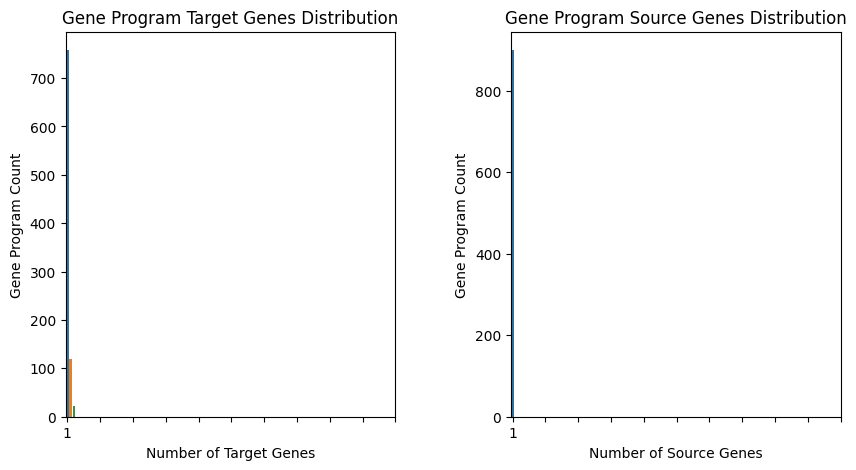

In [5]:
# Retrieve OmniPath GPs (source: ligand gene; target: receptor gene)
omnipath_gp_dict = extract_gp_dict_from_omnipath_lr_interactions(
    min_curation_effort=0,
    load_from_disk=False,
    save_to_disk=True,
    file_path=omnipath_ligand_receptor_interactions_file_path,
    plot_gp_gene_count_distributions=True)

# Retrieve unique source and target genes from OmniPath GPs to keep
# those genes when filtering
omnipath_genes = get_unique_genes_from_gp_dict(
    gp_dict=omnipath_gp_dict,
    retrieved_gene_entities=["sources", "targets"])

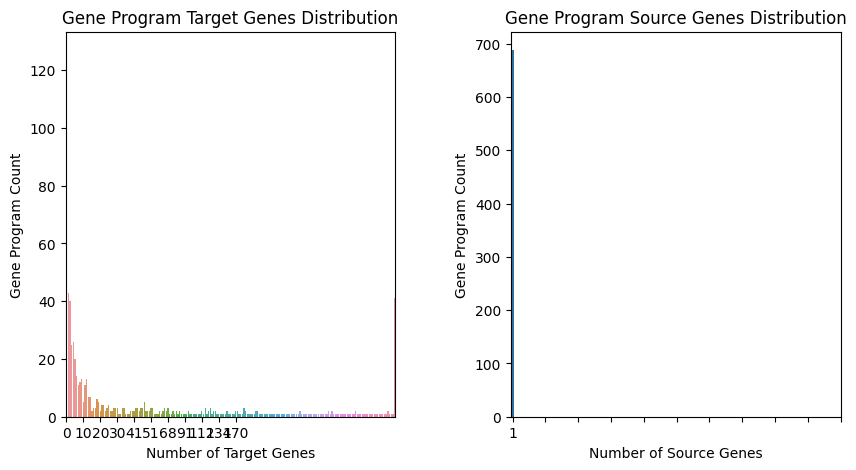

In [6]:
# Retrieve NicheNet GPs (source: ligand gene; target: target genes)
nichenet_gp_dict = extract_gp_dict_from_nichenet_ligand_target_mx(
    keep_target_genes_ratio=0.01,
    max_n_target_genes_per_gp=1000,
    load_from_disk=False,
    save_to_disk=True,
    file_path=nichenet_ligand_target_interactions_file_path,
    plot_gp_gene_count_distributions=True)

# Retrieve unique source genes from NicheNet GPs to keep
# those genes when filtering
nichenet_source_genes = get_unique_genes_from_gp_dict(
    gp_dict=nichenet_gp_dict,
    retrieved_gene_entities=["sources"])

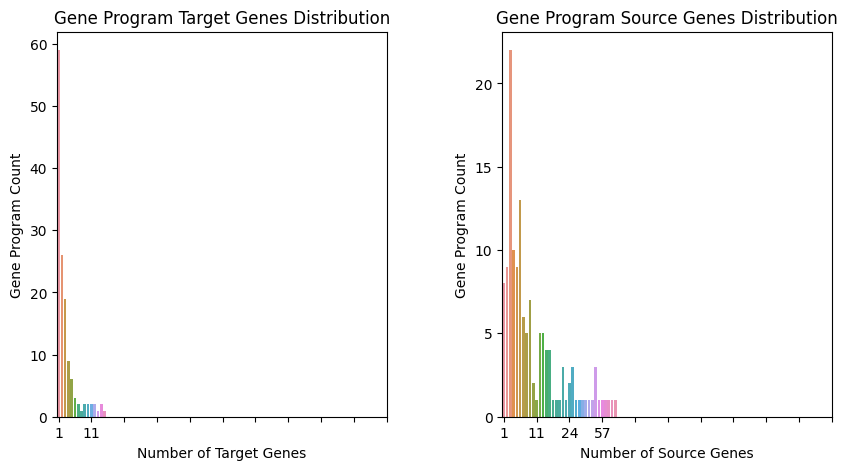

In [7]:
# Retrieve MEBOCOST GPs (source: enzyme genes; target: sensor genes)
mebocost_gp_dict = extract_gp_dict_from_mebocost_es_interactions(
    dir_path=mebocost_enzyme_sensor_interactions_folder_path,
    species="mouse",
    plot_gp_gene_count_distributions=True)

# Retrieve unique source and target genes from MEBOCOST GPs to keep
# those genes when filtering
mebocost_genes = get_unique_genes_from_gp_dict(
    gp_dict=mebocost_gp_dict,
    retrieved_gene_entities=["sources", "targets"])

In [8]:
# Add GPs into one dictionary
combined_gp_dict = dict(omnipath_gp_dict)
combined_gp_dict.update(nichenet_gp_dict)
combined_gp_dict.update(mebocost_gp_dict)

In [9]:
# Filter and combine GPs
combined_new_gp_dict = filter_and_combine_gp_dict_gps(
    gp_dict=combined_gp_dict,
    gp_filter_mode="subset",
    combine_overlap_gps=True,
    overlap_thresh_source_genes=0.9,
    overlap_thresh_target_genes=0.9,
    overlap_thresh_genes=0.9)

print("Number of gene programs before filtering and combining: "
      f"{len(combined_gp_dict)}.")
print(f"Number of gene programs after filtering and combining: "
      f"{len(combined_new_gp_dict)}.")

Number of gene programs before filtering and combining: 1725.
Number of gene programs after filtering and combining: 1583.


### 2.2 Load Data & Compute Spatial Neighbor Graph

- NicheCompass expects a precomputed spatial adjacency matrix stored in 'adata.obsp[adj_key]'.
- The user can customize the spatial neighbor graph construction based on the dataset and application of interest.

In [10]:
# Read data
adata = sc.read_h5ad(
        f"{so_data_folder_path}/spatial_atac_rna_seq_mouse_brain_rna.h5ad")
adata_atac = sc.read_h5ad(
        f"{so_data_folder_path}/spatial_atac_rna_seq_mouse_brain_atac.h5ad")

In [11]:
# Compute (separate) spatial neighborhood graphs
sq.gr.spatial_neighbors(adata,
                        coord_type="generic",
                        spatial_key=spatial_key,
                        n_neighs=n_neighbors)

# Make adjacency matrix symmetric
adata.obsp[adj_key] = (
    adata.obsp[adj_key].maximum(
        adata.obsp[adj_key].T))

### 2.3 Filter Genes & Peaks

In [12]:
if filter_genes:
    print("\nFiltering genes...")
    # Filter genes and only keep ligand, receptor, metabolitye enzyme, 
    # metabolite sensor and the 'n_hvg' highly variable genes (potential target
    # genes of nichenet)
    gp_dict_genes = get_unique_genes_from_gp_dict(
        gp_dict=combined_new_gp_dict,
            retrieved_gene_entities=["sources", "targets"])
    print(f"Starting with {len(adata.var_names)} genes.")
    sc.pp.filter_genes(adata,
                       min_cells=0)
    print(f"Keeping {len(adata.var_names)} genes after filtering genes with "
          "expression in 0 cells.")

    if (adata.layers[counts_key].astype(int).astype(np.float32).sum() == 
    adata.layers[counts_key].sum()): # raw counts
        hvg_flavor = "seurat_v3"
    else: # log normalized counts
        hvg_flavor = "seurat"

    sc.pp.highly_variable_genes(
        adata,
        layer=counts_key,
        n_top_genes=n_hvg,
        flavor=hvg_flavor,
        subset=False)

    # Get gene program relevant genes
    gp_relevant_genes = list(set(omnipath_genes + 
                                 nichenet_source_genes + 
                                 mebocost_genes))
    
    adata.var["gp_relevant"] = (
        adata.var.index.str.upper().isin(gp_relevant_genes))
    adata.var["keep_gene"] = (adata.var["gp_relevant"] | 
                              adata.var["highly_variable"])
    adata = adata[:, adata.var["keep_gene"] == True]
    print(f"Keeping {len(adata.var_names)} highly variable or gene program "
          "relevant genes.")
    adata = (adata[:, adata.var_names[adata.var_names.str.upper().isin(
                gp_dict_genes)].sort_values()])
    print(f"Keeping {len(adata.var_names)} genes after filtering genes not in "
          "gp dict.")
    
if filter_peaks:
    print("\nFiltering peaks...")
    print(f"Starting with {len(adata_atac.var_names)} peaks.")
    # Filter out peaks that are rarely detected to reduce GPU footprint of model
    min_cells = int(adata_atac.shape[0] * min_cell_peak_thresh_ratio)
    sc.pp.filter_genes(adata_atac, min_cells=min_cells)
    print(f"Keeping {len(adata_atac.var_names)} peaks after filtering peaks with "
          f"counts in less than {int(adata_atac.shape[0] * min_cell_peak_thresh_ratio)} cells.")


Filtering genes...
Starting with 22914 genes.
Keeping 22914 genes after filtering genes with expression in 0 cells.
Keeping 3950 highly variable or gene program relevant genes.
Keeping 2619 genes after filtering genes not in gp dict.

Filtering peaks...
Starting with 121068 peaks.
Keeping 121068 peaks after filtering peaks with counts in less than 4 cells.


### 2.4 Annotate Genes

In [13]:
adata, adata_atac = get_gene_annotations(
    adata=adata,
    adata_atac=adata_atac,
    gtf_file_path=gtf_file_path)

### 2.5 Add GP Mask to Data

In [14]:
# Add the GP dictionary as binary masks to the adata
add_gps_from_gp_dict_to_adata(
    gp_dict=combined_new_gp_dict,
    adata=adata,
    gp_targets_mask_key=gp_targets_mask_key,
    gp_sources_mask_key=gp_sources_mask_key,
    gp_names_key=gp_names_key,
    min_genes_per_gp=1,
    min_source_genes_per_gp=0,
    min_target_genes_per_gp=0,
    max_genes_per_gp=None,
    max_source_genes_per_gp=None,
    max_target_genes_per_gp=None)

### 2.6 Add Chromatin Accessibility Mask to Data

In [15]:
gene_peak_dict = generate_multimodal_pairing_dict(
    adata,
    adata_atac)

window_graph:   0%|          | 0/2583 [00:00<?, ?it/s]

In [16]:
adata_atac = add_multimodal_mask_to_adata(
    adata=adata,
    adata_atac=adata_atac,
    gene_peak_mapping_dict=gene_peak_dict)

print(f"Keeping {len(adata_atac.var_names)} peaks after filtering peaks with "
      "no matching genes in gp mask.")

Keeping 12816 peaks after filtering peaks with no matching genes in gp mask.


### 2.7 Explore Data

Number of nodes (observations): 9215
Number of gene node features: 2583
Number of peak node features: 12816


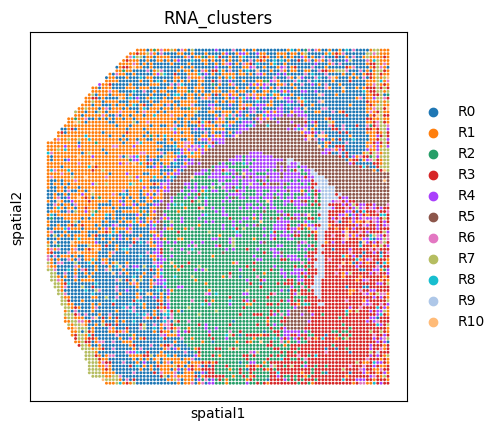

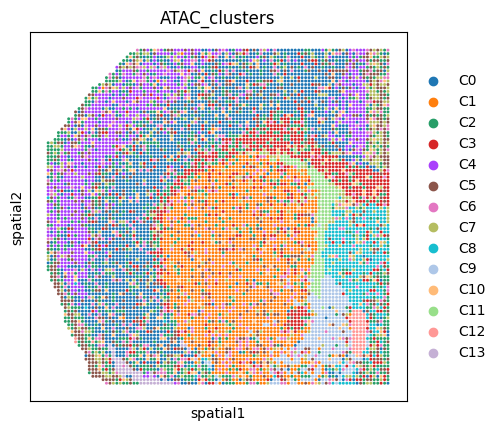

In [23]:
print(f"Number of nodes (observations): {adata.layers['counts'].shape[0]}")
print(f"Number of gene node features: {adata.layers['counts'].shape[1]}")
print(f"Number of peak node features: {adata_atac.layers['counts'].shape[1]}")

# Visualize spot-level annotated data in physical space
sc.pl.spatial(adata,
              color=rna_cluster_key,
              spot_size=20)
sc.pl.spatial(adata_atac,
              color=atac_cluster_key,
              spot_size=20) 

## 3. Model Training

### 3.1 Initialize, Train & Save Model

In [49]:
# Initialize model
model = NicheCompass(adata,
                     adata_atac,
                     counts_key=counts_key,
                     adj_key=adj_key,
                     gp_names_key=gp_names_key,
                     active_gp_names_key=active_gp_names_key,
                     gp_targets_mask_key=gp_targets_mask_key,
                     gp_sources_mask_key=gp_sources_mask_key,
                     latent_key=latent_key,
                     active_gp_thresh_ratio=active_gp_thresh_ratio,
                     log_variational=log_variational,
                     node_label_method=node_label_method)

--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, gene_expr_recon_dist: nb, include_chrom_access_recon_loss: True, chrom_access_recon_dist: nb 
NODE LABEL METHOD -> one-hop-norm
ACTIVE GP THRESHOLD RATIO -> 0.1
LOG VARIATIONAL -> True
ENCODER -> n_input: 15399, n_cond_embed_input: 0, n_layers: 1, n_hidden: 1371, n_latent: 1371, n_addon_latent: 0, conv_layer: gcnconv, n_attention_heads: 0, dropout_rate: 0.0
COSINE SIM GRAPH DECODER -> n_cond_embed_input: 0, n_cond_embed_output: 1371, dropout_rate: 0.0
MASKED GENE EXPRESSION DECODER -> n_input: 1371, n_cond_embed_input: 0, n_addon_input: 0, n_output: 5166
MASKED CHROMATIN ACCESSIBILITY DECODER -> n_input: 1371, n_cond_embed_input: 0, n_addon_input: 0, n_output: 25632
ONE HOP GCN NORM NODE LABEL AGGREGATOR -> self_loops: True


In [54]:
4 / 0

ZeroDivisionError: division by zero

In [55]:
import torch
torch.cuda.empty_cache()
import gc
gc.collect()

2213

In [56]:
# Train model
model.train(n_epochs=n_epochs,
            n_epochs_all_gps=n_epochs_all_gps,
            lr=lr,
            lambda_edge_recon=lambda_edge_recon,
            lambda_gene_expr_recon=lambda_gene_expr_recon,
            lambda_l1_masked=lambda_l1_masked,
            edge_batch_size=edge_batch_size,
            use_cuda_if_available=use_cuda_if_available)


--- INITIALIZING TRAINER ---
Number of training nodes: 8293
Number of validation nodes: 922
Number of training edges: 50471
Number of validation edges: 5607

--- MODEL TRAINING ---



KeyboardInterrupt



In [ ]:
# Compute latent neighbor graph
sc.pp.neighbors(model.adata,
                use_rep=latent_key,
                key_added=latent_key)


# Compute UMAP embedding
sc.tl.umap(model.adata,
           neighbors_key=latent_key)

In [ ]:
# Save trained model
model.save(dir_path=f"{model_folder_path}/{current_timestamp}",
           overwrite=True,
           save_adata=True,
           adata_file_name="adata.h5ad",
           save_adata_atac=True,
           adata_atac_file_name=f"adata_atac.h5ad")

## 4. Analysis

In [ ]:
# Load trained model
load_timestamp = "17052023_140928"
model = NicheCompass.load(dir_path=f"{model_folder_path}/{load_timestamp}",
                          adata=None,
                          adata_file_name="adata.h5ad",
                          gp_names_key=gp_names_key)

In [ ]:
# Check number of active GPs
active_gps = model.get_active_gps()
print(f"Number of total gene programs: {len(model.adata.uns[gp_names_key])}.")
print(f"Number of active gene programs: {len(active_gps)}.")

In [ ]:
# Inspect GPs
gp_summary_df = model.get_gp_summary()
gp_summary_df[gp_summary_df["gp_active"] == True].head()

### 4.1 NicheCompass Latent Manifold Overview